<a href="https://www.kaggle.com/code/sahilr05/food-recommendation?scriptVersionId=106342252" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv
/kaggle/input/food-com-recipes-and-user-interactions/ingr_map.pkl
/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_train.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_test.csv
/kaggle/input/food-com-recipes-and-user-interactions/PP_users.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_validation.csv


In [2]:
a = pd.read_csv("/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv")
a.head(2)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."


In [3]:
b = pd.read_csv("/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv")
b.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


In [4]:
a.shape , b.shape

((1132367, 5), (231637, 12))

In [5]:
# Data set is big so take some random samples

a = a.sample(50000)
b = b.sample(50000)

In [6]:
data = pd.merge(a,b, right_on='id',left_on='recipe_id')

In [7]:
data.shape

(10954, 17)

In [8]:
data.head(2)

,user_id,recipe_id,date,rating,review,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,224170,187130,2009-05-05,5,Yippee! These sandwiches were awesome!! I se...,chicken and roasted red pepper panini style sa...,187130,20,352814,2006-09-20,"['30-minutes-or-less', 'time-to-make', 'course...","[331.3, 36.0, 7.0, 71.0, 42.0, 47.0, 2.0]",10,"['cut 8 thick slice of foccacia bread', 'mix m...","i love chicken and roasted red peppers, so i p...","['cooked chicken breast', 'roasted red peppers...",7
1,1063039,143101,2008-12-08,5,Nearly didn't bother with this after reading t...,bryanna s yeasted pastry dough no fat,143101,30,208121,2005-10-28,"['30-minutes-or-less', 'time-to-make', 'course...","[104.4, 0.0, 4.0, 4.0, 6.0, 0.0, 7.0]",24,"['the potatoes need to be just potatoes , no m...",and when she says fat free she means it. i am...,"['non-dairy milk substitute', 'mashed potatoes...",8


In [9]:
data.drop(["user_id","submitted","contributor_id","id"],axis=1,inplace=True)

In [10]:
data.describe()

,recipe_id,rating,minutes,n_steps,n_ingredients
count,10954.000000,10954.000000,10954.000000,10954.000000,10954.000000
mean,162400.539985,4.427880,87.508490,9.694084,8.924229
std,131467.279537,1.236025,335.325705,5.792100,3.611650
min,135.000000,0.000000,0.000000,1.000000,1.000000
25%,54929.250000,4.000000,22.000000,6.000000,6.000000
50%,119065.000000,5.000000,40.000000,9.000000,9.000000
75%,244262.750000,5.000000,70.000000,12.000000,11.000000
max,536859.000000,5.000000,11540.000000,70.000000,28.000000


* Minutes & n_steps have outliear

In [11]:
data[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] = data.nutrition.str.split(",",expand=True) 
data['calories'] = data['calories'].apply(lambda x: x.replace("[" ,""))
data['carbohydrates'] = data['carbohydrates'].apply(lambda x: x.replace("]" ,""))
data[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] =  data[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']].astype(float)

<AxesSubplot:xlabel='n_steps', ylabel='Density'>

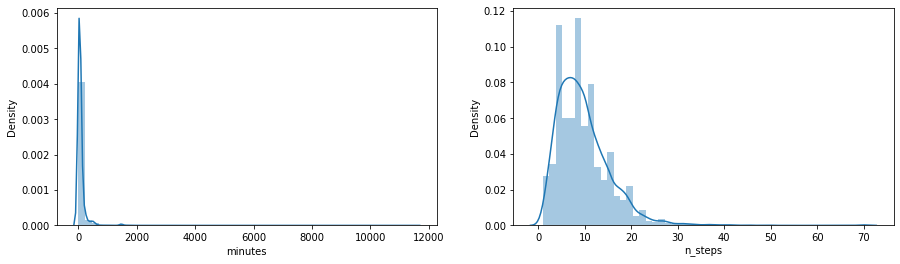

In [12]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.distplot(data["minutes"],ax=ax[0])
sns.distplot(data["n_steps"],ax=ax[1])

<AxesSubplot:>

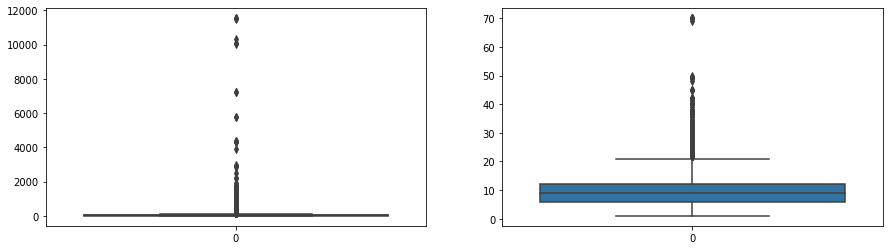

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.boxplot(data=data["minutes"],ax=ax[0])
sns.boxplot(data=data["n_steps"],ax=ax[1])

In [14]:
q1 = np.percentile(data["minutes"],25)
q3 = np.percentile(data["minutes"],75)
IQR = q3- q1
upper = q3 + 1.5*IQR
lower = q1 - 1.5*IQR

data = data.drop((data[data["minutes"]>=upper].index | data[data["minutes"]<=lower].index),axis=0)

In [15]:
q1 = np.percentile(data["n_steps"],25)
q3 = np.percentile(data["n_steps"],75)
IQR = q3- q1
upper = q3 + 1.5*IQR
lower = q1 - 1.5*IQR

data = data.drop((data[data["n_steps"]>=upper].index | data[data["n_steps"]<=lower].index),axis=0)

<AxesSubplot:>

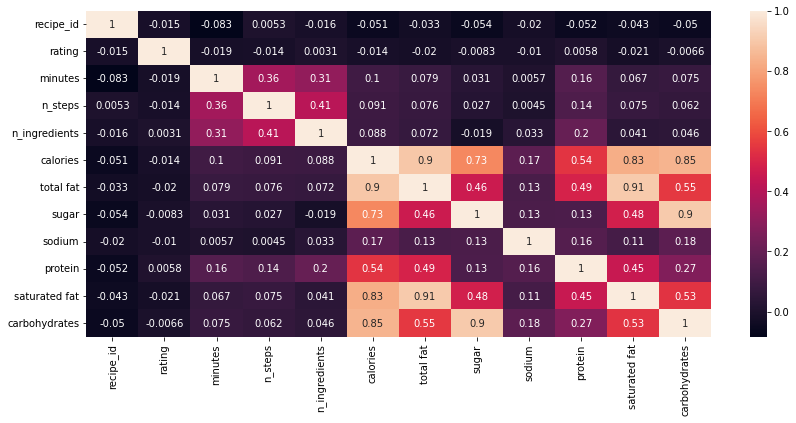

In [16]:
plt.figure(figsize=(14,6))
sns.heatmap(data.corr(),annot=True)

<AxesSubplot:xlabel='n_ingredients', ylabel='minutes'>

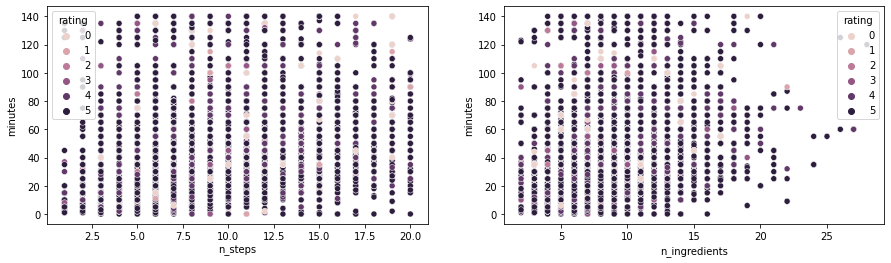

In [17]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.scatterplot(data=data,x="n_steps",y="minutes" ,hue="rating",ax=ax[0])
sns.scatterplot(data=data,x="n_ingredients",y="minutes" ,hue="rating",ax=ax[1])

<AxesSubplot:xlabel='carbohydrates', ylabel='sugar'>

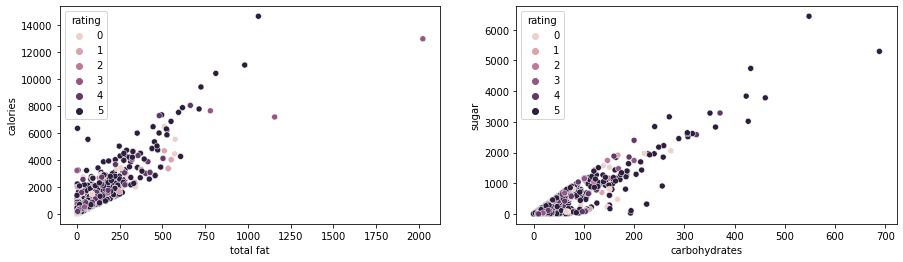

In [18]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.scatterplot(data=data,x="total fat",y="calories" ,hue="rating",ax=ax[0])
sns.scatterplot(data=data,x="carbohydrates",y="sugar" ,hue="rating",ax=ax[1])

<AxesSubplot:xlabel='n_steps', ylabel='n_ingredients'>

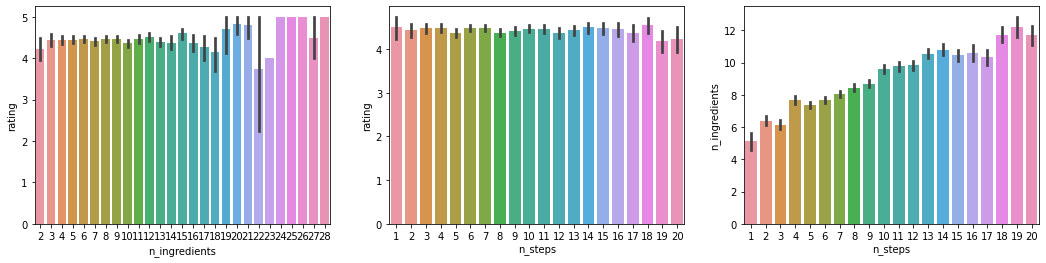

In [19]:
fig,ax = plt.subplots(1,3,figsize=(18,4))
sns.barplot(data=data,y="rating",x="n_ingredients",ax=ax[0])
sns.barplot(data=data,y="rating",x="n_steps",ax=ax[1])
sns.barplot(data=data,y="n_ingredients",x="n_steps",ax=ax[2])

In [20]:
data.isnull().sum()
data.dropna(inplace=True)

In [21]:
nonveg_ingred = ["egg","egg whites",]
def ingredient_check(data):
    veg = 0 
    for a in literal_eval(data):
        if a in nonveg_ingred:
            veg = 1
        else:
            veg = 0
    return veg
data["non veg"] = data["ingredients"].apply(ingredient_check)

In [22]:
data.columns

Index(['recipe_id', 'date', 'rating', 'review', 'name', 'minutes', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'calories', 'total fat', 'sugar', 'sodium', 'protein',
       'saturated fat', 'carbohydrates', 'non veg'],
      dtype='object')

In [23]:
data["non veg"].value_counts()

0    9277
1      64
Name: non veg, dtype: int64

In [24]:
rec = data[["recipe_id","rating","name","tags","description","ingredients",]]

In [25]:
rate = rec.groupby("name")["rating"].sum().reset_index()

In [26]:
import nltk

In [27]:
rec.duplicated().sum()
rec.drop_duplicates(inplace=True)

In [28]:
rec.reset_index(drop=True,inplace=True)

In [29]:
rec.head(2)

,recipe_id,rating,name,tags,description,ingredients
0,187130,5,chicken and roasted red pepper panini style sa...,"['30-minutes-or-less', 'time-to-make', 'course...","i love chicken and roasted red peppers, so i p...","['cooked chicken breast', 'roasted red peppers..."
1,27652,5,honey garlic grilled chicken,"['60-minutes-or-less', 'time-to-make', 'course...",i saw the word garlic that is all it takes for...,"['oil', 'fresh cilantro', 'honey', 'lime juice..."


In [30]:
import string

def convert_to_list(data):
    a = data.replace("-","").replace("[","").replace("]","")
#     a = ''.join([i for i in a if not i.isdigit()])
    a = a.translate(str.maketrans('', '', string.punctuation))
    return a

In [31]:
rec["tags"] = rec["tags"].apply(lambda x: convert_to_list(x))
rec["ingredients"] = rec["ingredients"].apply(lambda x: convert_to_list(x))
rec["description"] = rec["description"].apply(lambda x: convert_to_list(x))

In [32]:
rec["rec"] = rec["tags"] + rec["description"] + rec["ingredients"]
rec = rec[~rec.duplicated("name")]
rec.reset_index(drop=True,inplace=True)

In [33]:
rec.to_csv("food.csv")

In [34]:
cv = TfidfVectorizer()
rec_tfidf = cv.fit_transform(rec["rec"])
name_tfidf = cv.fit_transform(rec["name"])
rec_consin_sim = linear_kernel(rec_tfidf,rec_tfidf)
name_consin_sim = linear_kernel(name_tfidf,name_tfidf)

In [35]:
indices = pd.Series(rec.index,index=rec['name'])
def recommendation(data,sim):
    re_li = []
    df = pd.DataFrame([])
    ind = indices[data]
#     ind = rec[rec["name"]==data].index[0]
    sim_score = list(enumerate(sim[ind]))
    sim_score = sorted(sim_score,key=lambda x:x[1],reverse=True)
    sim_score = sim_score[0:10]
    rec_indices = [i[0] for i in sim_score]
    for i in rec_indices:
        re_li.append(rec.iloc[i]["name"])
        
    return re_li

# recommendation("potatoes oh  brian")

In [36]:
# Recommendation based on name

recommendation(rec[:1]["name"][0],name_consin_sim)

['chicken and roasted red pepper panini style sandwiches',
 'roasted red pepper provolone panini',
 'tomato and roasted red pepper soup',
 'roasted red pepper cream soup',
 'raspberry and roasted red pepper chicken fillets',
 'roasted red pepper and rosemary hummus',
 'roasted red pepper and goat cheese dip',
 'roasted red bell pepper pasta',
 'pasta with creamy red roasted pepper sauce',
 'buffalo  chicken panini']

In [37]:
# Recommendation based on tags, description, ingredients

recommendation(rec[:1]["name"][0],rec_consin_sim)

['chicken and roasted red pepper panini style sandwiches',
 'roasted red pepper cream soup',
 'oven roasted chicken  with roasted garlic and french bread',
 'garlic chicken breasts',
 'low fat spinach and artichoke dip',
 'caprese panini',
 'baked chicken soup',
 'low fat cashew chicken  oriental dish',
 'italian sausage and chicken',
 'chicken salad and avocado sandwich']